# Absolute vs relative performance estimation

Absolute performance estimation is labour intensive as we need many samples to get decent performance.
Hence, it is hard to estimate performance improvements when changes are small, i.e., you do model maintenance.


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from keras.optimizers import Adam
from plotnine import *

from model_library.display_code import display_source
from model_library.dataframe_manipulation import combine_two_dataframes

In [2]:
import sys
sys.path.append('../../image-generation/')

## I. Data generation

Relative performance estimation requires lots of unlabelled data what si not part of [MNIST dataset](https://www.kaggle.com/datasets/hojjatk/mnist-dataset). To bypass this issue, we use an image generator that was trained on MNIST dataset.
This does not simulate new numbers perfectly but it allows to see how estimation techniques work.


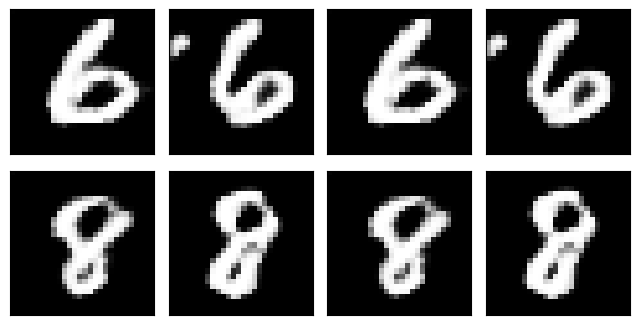

In [3]:
from keras.saving import load_model as load_keras_model
from image_generators.conditional_gan import generate_samples
from image_generators.conditional_gan.default_components import config

generator = load_keras_model('../../image-generation/models/mnist_gan_generator.keras') 

sixes = generate_samples(generator, config, label=6, sample_count=4, verbose=0)
eights = generate_samples(generator, config, label=8, sample_count=4, verbose=0)

fig, axs = plt.subplots(2, 4, figsize=(8, 4))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.setp(axs, xticks=[], yticks=[], xlabel='', ylabel='', aspect='equal')
axs[0, 0].imshow(sixes[0], cmap='gray', vmin=0, vmax=1)
axs[0, 1].imshow(sixes[1], cmap='gray', vmin=0, vmax=1)
axs[0, 2].imshow(sixes[0], cmap='gray', vmin=0, vmax=1)
axs[0, 3].imshow(sixes[1], cmap='gray', vmin=0, vmax=1)
axs[1, 0].imshow(eights[0], cmap='gray', vmin=0, vmax=1)
axs[1, 1].imshow(eights[1], cmap='gray', vmin=0, vmax=1)
axs[1, 2].imshow(eights[0], cmap='gray', vmin=0, vmax=1)
axs[1, 3].imshow(eights[1], cmap='gray', vmin=0, vmax=1)
plt.show()

For conveniance, we use a helper function that allows us to generate $2n$ samples with equal proportions for both classes.  

In [4]:
from model_library.data_loaders import generate_image_pairs
display_source(generate_image_pairs)

```python
def generate_image_pairs(n: int, generator: keras.Model, config,
                         class_0: int, class_1: int, verbose: int = 0) -> Tuple[tf.Tensor, tf.Tensor]:
    """
    Generates n samples of digits for both classes separately, i.e., the outcome contains 2 * n samples.
    Final labels will be zero and one instead of original class labels defined as arguments.
    """
    images = tf.reshape(tf.stack([
        generate_samples(generator, config, label=class_0, sample_count=n, verbose=verbose),
        generate_samples(generator, config, label=class_1, sample_count=n, verbose=verbose)
    ], axis=1), (-1, 28, 28))
    labels = tf.tile(tf.constant([0, 1], 'int32'), (n,))

    return images, labels

```

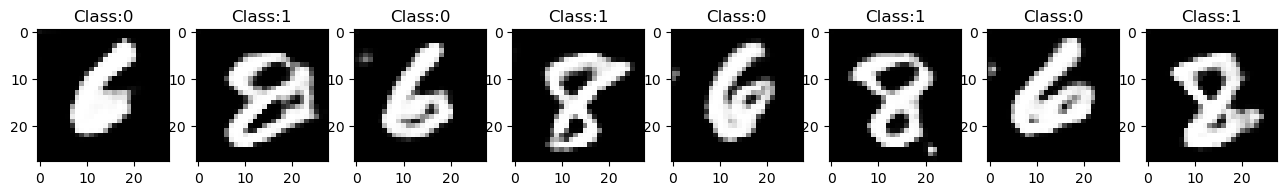

In [5]:
images, labels = generate_image_pairs(4, generator, config, 6, 8)
fig, axs = plt.subplots(1, 8, figsize=(16, 4))
for i in range(0, 8): 
    axs[i].imshow(images[i], cmap='gray', vmin=0, vmax=1)
    axs[i].set_title(f'Class:{labels[i]}')

## II. Model training

From the previous notebook [01_scaling_laws_on_minst_data.ipynb](./01_scaling_laws_on_minst_data.ipynb) we know that logistic regression models perform roughly the same when trained on 50 or 75 image pairs. Let us train two such models and compare their performance on generated images.  

In [6]:
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

training_data = dict()
n_max = min(min(sum(train_labels == 6), sum(train_labels == 8)), 5850)
training_data['6'] = tf.random.shuffle(train_images[train_labels == 6]/255.0)[:n_max]
training_data['8'] = tf.random.shuffle(train_images[train_labels == 8]/255.0)[:n_max]
assert(len(training_data['6']) == len(training_data['8']))

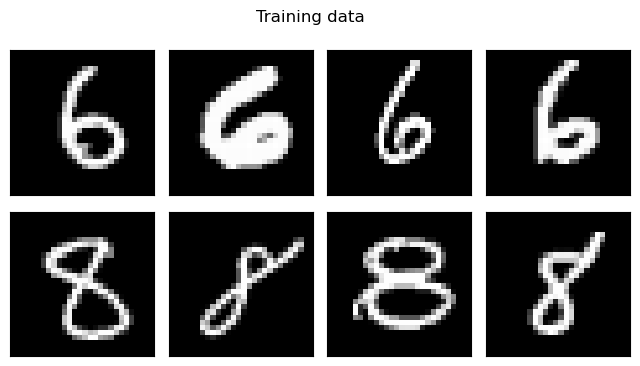

In [7]:
fig, axs = plt.subplots(2, 4, figsize=(8, 4))
plt.suptitle('Training data')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.setp(axs, xticks=[], yticks=[], xlabel='', ylabel='', aspect='equal')
for i in range(4):
    axs[0, i].imshow(training_data['6'][i], cmap='gray', vmin=0, vmax=1)
    axs[1, i].imshow(training_data['8'][i], cmap='gray', vmin=0, vmax=1)
plt.show()

In [8]:
from model_library.logreg import mnist_logreg_model
logreg = mnist_logreg_model()
logreg.summary()
adam_lr = Adam(learning_rate=1e-3)
logreg.compile(optimizer=adam_lr, loss='binary_crossentropy', metrics=['accuracy'])

Model: "Logistic_regression"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           785 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 785 (3.07 KB)

 Trainable params: 785 (3.07 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
from model_library.data_loaders import get_image_pairs
from model_library.model_training import train_binary_classifier

N = 50
model_1 = mnist_logreg_model()
adam_lr = Adam(learning_rate=1e-3)
model_1.compile(optimizer=adam_lr, loss='binary_crossentropy', metrics=['accuracy'])
images, labels = get_image_pairs(N, training_data, '6', '8')
model_1, _ = train_binary_classifier(model_1, images, labels , epochs=10, batch_size=32, collect_telemetry=False)

N = 75
model_2 = mnist_logreg_model()
adam_lr = Adam(learning_rate=1e-3)
model_2.compile(optimizer=adam_lr, loss='binary_crossentropy', metrics=['accuracy'])
images, labels = get_image_pairs(N, training_data, '6', '8')
model_2, _ = train_binary_classifier(model_2, images, labels , epochs=10, batch_size=32, collect_telemetry=False)

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

## III. Absolute performance evaluation

Next we are going to evaluate model performances on 1000 image pairs which a relatively decent testset size. 
Labelled test sets that are several orders bigger are quite rare  -- why would you waste precious data for testing.  

In [10]:
K = 20
N = 1000
telemetry = (pd.DataFrame(list(range(K)), columns=['experiment'])
             .set_index('experiment')
             .assign(model_1=np.nan, model_2=np.nan))

for i in tqdm(range(len(telemetry))):
    test_images, test_labels = generate_image_pairs(N, generator, config, 6, 8)
    telemetry.loc[i, 'model_1'] = model_1.evaluate(test_images, test_labels, verbose=0)[1] 
    telemetry.loc[i, 'model_2'] = model_2.evaluate(test_images, test_labels, verbose=0)[1] 

  0%|          | 0/20 [00:00<?, ?it/s]

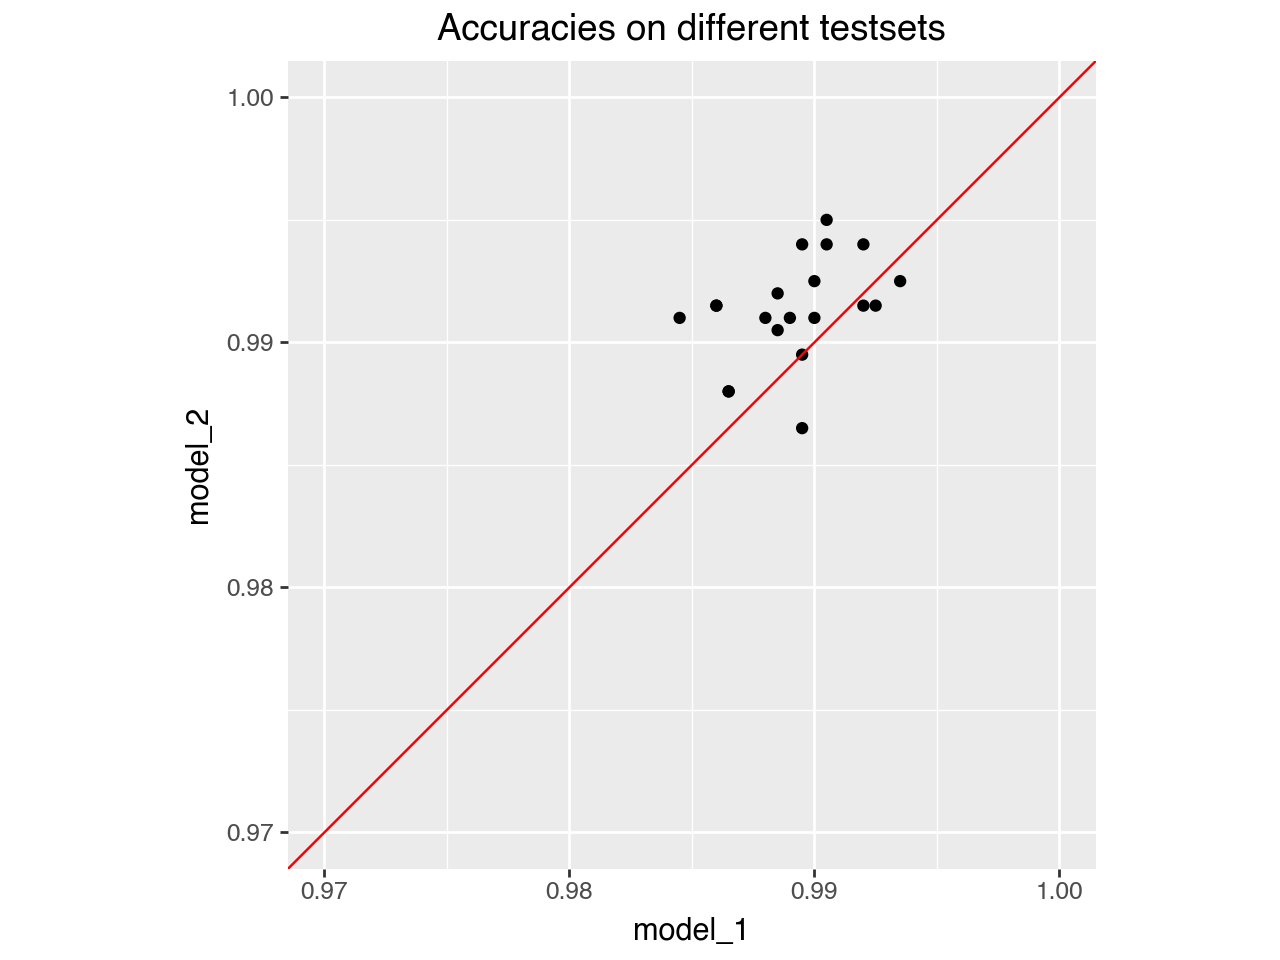

In [11]:
p  = ggplot(telemetry) 
p += geom_point(aes(x='model_1', y='model_2')) 
p += coord_fixed(ratio=1) 
p += xlim([0.97, 1.00]) 
p += ylim([0.97, 1.00])
p
p += geom_abline(intercept=0, slope=1, color='red')
p += ggtitle('Accuracies on different testsets')
p

## III. Relative performance evaluation

Relative performance evaluation assumes the existence of a large unlabelled test set which will be later on lazily labelled -- we label only these instances that matter. In this presentation, we use true labels for convenience, as manual labelling takes time.   

**1. Evaluate both models on unlabelled testset**

In [12]:
N = 100000
test_images, test_labels = generate_image_pairs(N, generator, config, 6, 8, verbose=1)

predictions_1 = tf.squeeze(model_1.predict(test_images) >= 0.5)
predictions_2 = tf.squeeze(model_2.predict(test_images) >= 0.5)

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 90s 29ms/step 
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 91s 29ms/step 
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 1s 218us/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 1s 213us/step


**2. Estimate maximal accuracy difference between models** 

In [13]:
p_d = tf.reduce_mean(tf.cast(predictions_1 != predictions_2, 'float')).numpy()
print(f'Models differ on {p_d * 100:.2f}% samples in the unlabelled test set')

Models differ on 1.19% samples in the unlabelled test set


**3. Label a random sample of the difference set** 

In [14]:
dif_index = tf.squeeze(tf.where(predictions_1 != predictions_2))
dif_images = tf.gather(test_images, dif_index)
dif_predictions_1 = tf.gather(predictions_1, dif_index)
dif_predictions_2 = tf.gather(predictions_2, dif_index)

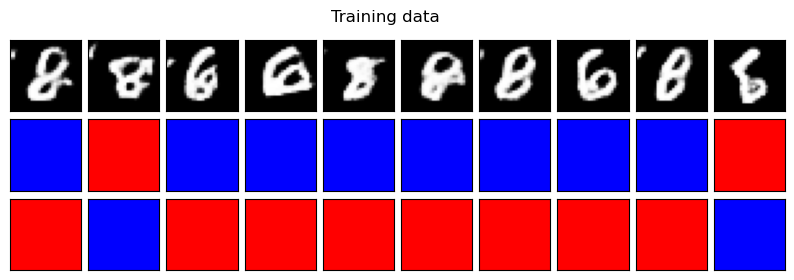

In [15]:
fig, axs = plt.subplots(3, 10, figsize=(10, 3))
plt.suptitle('Training data')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.setp(axs, xticks=[], yticks=[], xlabel='', ylabel='', aspect='equal')
for i in range(10):
    axs[0, i].imshow(dif_images[i], cmap='gray', vmin=0, vmax=1)
    axs[1, i].set_facecolor('blue' if dif_predictions_1[i].numpy() else 'red')
    axs[2, i].set_facecolor('blue' if dif_predictions_2[i].numpy() else 'red')


Let use corrrect labels to see which model is correct on a sample of size $1000$.

In [16]:
N = 1000

# Perform manual labbeling of both models 
dif_true_labels = tf.cast(tf.gather(test_labels, dif_index), 'bool')
model_1_correct = tf.reduce_sum(tf.cast(dif_predictions_1[:1000] == dif_true_labels[:1000], 'int32')).numpy()
model_2_correct = tf.reduce_sum(tf.cast(dif_predictions_2[:1000] == dif_true_labels[:1000], 'int32')).numpy()

relative_difference = (model_2_correct - model_1_correct)/N
print(f'Model 1 is correct {model_1_correct} and model 2 is correct {model_2_correct} number of cases.')
print(f'Model 2 is {relative_difference * 100:2.1f} percent points better on difference set.')

Model 1 is correct 454 and model 2 is correct 546 number of cases.
Model 2 is 9.2 percent points better on difference set.


**4. Compute the relative difference on the entire testset**

In [17]:
performance_difference = p_d * relative_difference
print(f'Model 2 is {performance_difference*100:2.3f} percent points better on the entire test set')

Model 2 is 0.109 percent points better on the entire test set
